# notebooks/exploratory_data_analysis.ipynb

In [24]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
file_path = '../data/FP-data.csv'

In [26]:
try:
    # The CSV already has a header row, so read it directly
    df = pd.read_csv(file_path, encoding='latin-1')
    # Standardize column names just in case
    df.columns = ['sentence', 'label']
    # Clean label strings (remove surrounding quotes/whitespace, lower-case)
    df['label'] = df['label'].astype(str).str.strip().str.replace('"', '').str.lower()
    print("Data successfully read!\n")
except Exception as e:
    print(f"Could not read the file: {e}")

# Show first 5 rows to verify
df.head()

Data successfully read!



,sentence,label
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5842 non-null   object
 1   label     5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [28]:
df.describe()

,sentence,label
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [29]:
# Inspect unique raw labels first
print("Unique raw labels:", df['label'].unique())

# If labels are textual already (positive/negative/neutral), just normalize
expected = {"positive", "negative", "neutral"}
if set(df['label'].unique()) <= expected:
    df['label_name'] = df['label']  # already descriptive
else:
    # Fallback: try numeric mapping
    numeric_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
    # Coerce to numeric when possible
    df['label_numeric'] = pd.to_numeric(df['label'], errors='coerce')
    df['label_name'] = df['label_numeric'].map(numeric_map)

# Report any unmapped labels
unmapped = df[df['label_name'].isna()]['label'].unique()
if len(unmapped):
    print("Unmapped labels found (please inspect):", unmapped)

print(df['label_name'].value_counts())

Unique raw labels: ['positive' 'negative' 'neutral']
label_name
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


In [30]:
df.isna().sum()

sentence      0
label         0
label_name    0
dtype: int64

/var/folders/ws/qwb72h7d5bq8gn5bnw4hw33m0000gn/T/ipykernel_26736/970636141.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


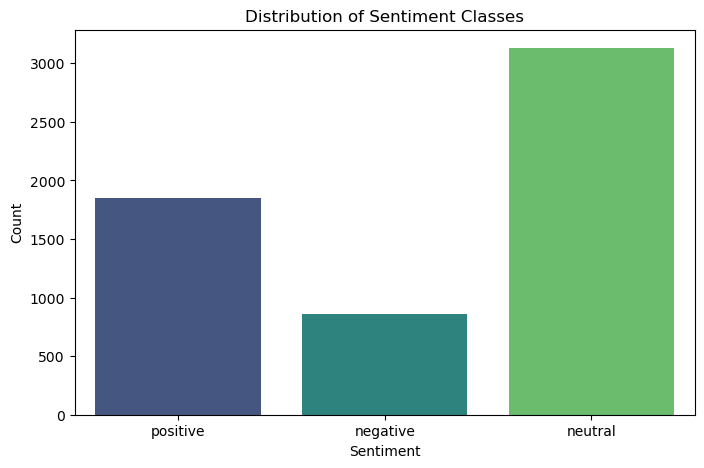

In [38]:
# Visualize the distribution with a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(x='label_name', data=df, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

count    5842.000000
mean      117.059397
std        56.435712
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: sentence_length, dtype: float64


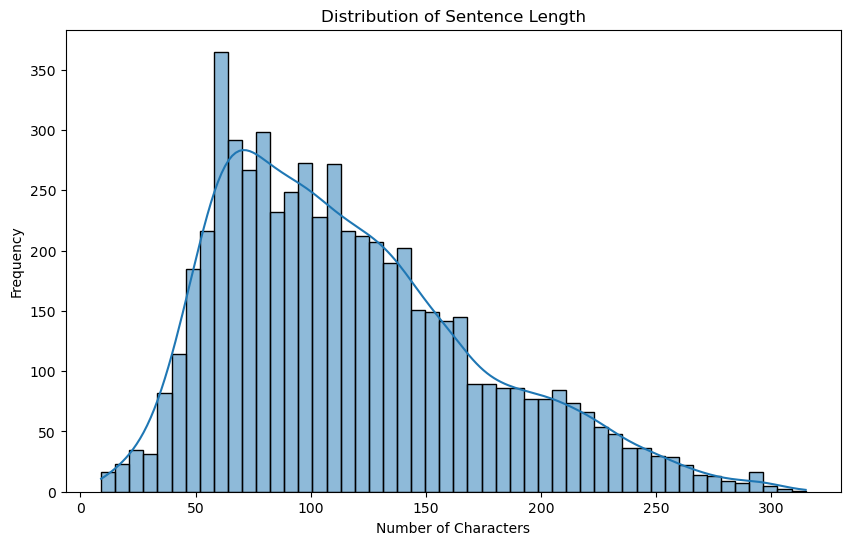

In [32]:
# Create a new column for the length of each sentence
df['sentence_length'] = df['sentence'].apply(len)

# Show statistics for the sentence lengths
print(df['sentence_length'].describe())

# Visualize the distribution of sentence lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['sentence_length'], bins=50, kde=True)
plt.title('Distribution of Sentence Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# SPLIT DATASET INTO train, test and val (80/10/10)

In [33]:
from sklearn.model_selection import train_test_split

In [44]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_name'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label_name'],
    random_state=42
)

print(f"Train: {len(train_df)}, Test: {len(test_df)}, Val: {len(val_df)}")
print("Train label distribution:\n", train_df['label_name'].value_counts(normalize=True))
print("Validation label distribution:\n", val_df['label_name'].value_counts(normalize=True))
print("Test label distribution:\n", test_df['label_name'].value_counts(normalize=True))

Train: 4673, Test: 585, Val: 584
Train label distribution:
 label_name
neutral     0.535844
positive    0.316927
negative    0.147229
Name: proportion, dtype: float64
Validation label distribution:
 label_name
neutral     0.535959
positive    0.316781
negative    0.147260
Name: proportion, dtype: float64
Test label distribution:
 label_name
neutral     0.535043
positive    0.317949
negative    0.147009
Name: proportion, dtype: float64


In [45]:
train_df.head()

,sentence,label,label_name,sentence_length
1247,"National Conciliator Juhani Salonius , who met...",negative,negative,149
966,The goal is to secure the company 's profitabi...,neutral,neutral,72
4456,M-real Corporation Stock Exchange Announcement...,neutral,neutral,270
1385,$FB watching for bounce tomorrow,positive,positive,32
5190,That would be an increase from estimated sales...,positive,positive,73


In [ ]:
# format and save train, val, and test splits as CSVs
label2id = {'neutral': 0, 'positive': 1, 'negative': 2}
 
# Prepare train set
train_to_save = train_df[['sentence', 'label_name']].copy()
train_to_save['label_id'] = train_to_save['label_name'].map(label2id)
train_to_save.to_csv("../data/train.csv", index=False)
 
# Prepare validation set
val_to_save = val_df[['sentence', 'label_name']].copy()
val_to_save['label_id'] = val_to_save['label_name'].map(label2id)
val_to_save.to_csv("../data/val.csv", index=False)
 
# Prepare test set
test_to_save = test_df[['sentence', 'label_name']].copy()
test_to_save['label_id'] = test_to_save['label_name'].map(label2id)
test_to_save.to_csv("../data/test.csv", index=False)
 
print("Saved train.csv, val.csv, and test.csv with columns: sentence, label_name, label_id")

Saved train.csv, val.csv, and test.csv with columns: sentence, label_name, label_id
